# Parallel fitting example: fitting PSFs to many sources in an image

In [1]:
mosaic = '/home/tom/Data/Orion/O:IR Images/Orion_A_J_3x3.fits'

The goal here is to fit a (simple Gaussian) PSF to many sources in a mosaic in parallel. For this example, we are only concerned with objects that are isolated, not blended.

In [2]:
import numpy as np
from scipy.spatial import KDTree
from astropy.io import fits
from photutils.detection import DAOStarFinder
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import TRFLSQFitter

In order to fit the PSF to all the sources, we will extract cutouts for each source - the following give the size of the cutouts:

In [3]:
cutout_half_size = 7
cutout_size = cutout_half_size * 2

In [4]:
data = fits.getdata(mosaic)

We start off by identifying sources in the image:

In [5]:
daofind = DAOStarFinder(fwhm=3.0, threshold=2, exclude_border=True)  
sources = daofind(data)
sources.sort('flux')
sources.reverse()
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64
26917,3884.2335,6606.03,0.43420566,0.030318527,0.019340437,25,0,7983.5112,4284.672,-9.079794
110674,3464.8162,21333.794,0.62546283,0.11579821,0.057325725,25,0,8864.6318,4046.6838,-9.0177482
697,7731.2634,329.98268,0.61947249,0.015867425,0.02890305,25,0,8499.2178,3905.8125,-8.9792785
110851,3632.1856,21356.13,0.79317903,0.095062375,0.027615207,25,0,8385.2959,3398.9578,-8.8283644
112506,636.70922,21594.205,0.66280496,-0.038072657,0.039217582,25,0,7677.0088,3391.6653,-8.8260325
114975,3627.554,21937.696,0.63065026,-0.44563323,-0.10154261,25,0,7576.3989,3365.9592,-8.8177721
28148,443.98574,6780.0432,0.91651249,0.060148999,0.050695177,25,0,8605.9316,3206.1289,-8.7649524
54612,7856.3664,11440.426,0.50367525,-0.40085071,0.11791269,25,0,6731.7866,3161.2916,-8.7496614
27646,374.27445,6713.102,0.67404828,0.11716837,0.017089087,25,0,7141.7378,3143.4647,-8.7435215


Now construct a KDTree in order to exclude any objects that are not isolated within the cutout:

In [6]:
x = sources['xcentroid']
y = sources['ycentroid']

In [7]:
positions = np.array([x, y]).T

In [8]:
tree = KDTree(positions)

In [9]:
distance, index = tree.query(positions, k=2)

In [10]:
include = (distance[:, 1] > cutout_half_size) & (x > cutout_half_size) & (x < data.shape[1]) & (y > cutout_half_size) & (y < data.shape[0])

Check how many sources we are including and excluding:

In [11]:
np.sum(include)

np.int64(168179)

In [12]:
np.sum(~include)

np.int64(24286)

Filter table and construct a 3D array where each slice is a separate cutout:

In [13]:
sources = sources[include]

In [14]:
cutouts = np.empty((len(sources), cutout_size, cutout_size))

In [15]:
for index in range(len(sources)):
    x = int(round(sources[index]['xcentroid']))
    y = int(round(sources[index]['ycentroid']))
    cutouts[index, :, :] = data[y-cutout_half_size:y+cutout_half_size,x-cutout_half_size:x+cutout_half_size]

Fitting convergence doesn't work well if data values are very large or very small, so we normalize the cutouts by the originally determined peak:

In [16]:
cutouts /= sources['peak'][:, None, None]

Visualize the first 36 sources

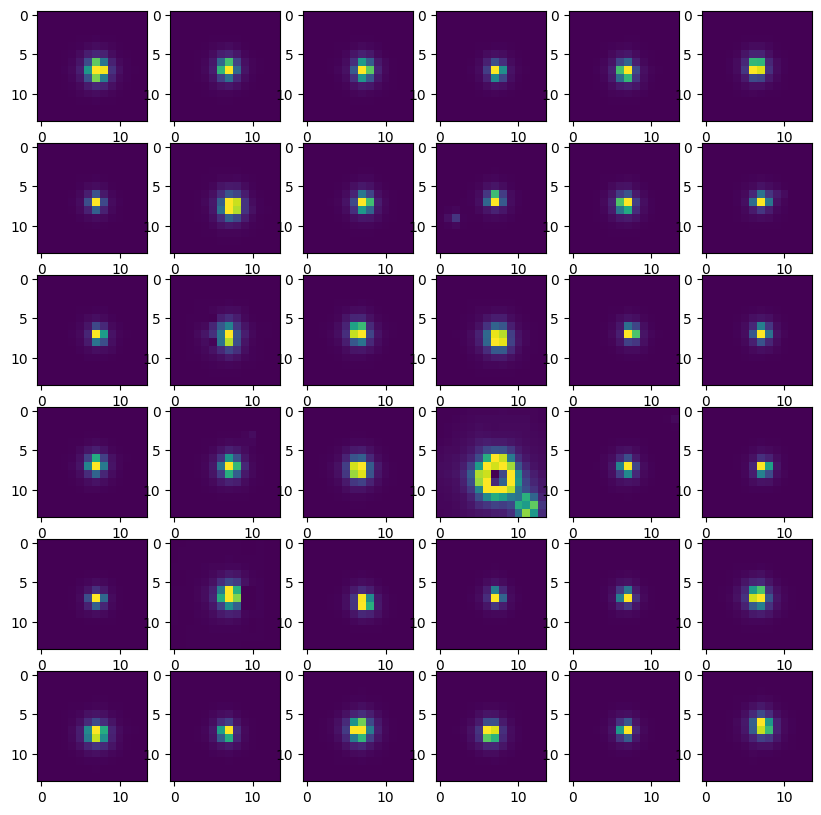

In [17]:
fig = plt.figure(figsize=(10, 10))
for index in range(36):
    ax = fig.add_subplot(6, 6, index + 1)
    ax.imshow(cutouts[index], vmax=1)

Now set up fitter and a reasonable 2D Gaussian model with fixed rotation and bounds on the position to avoid moving too far away from the center:

In [18]:
fitter = TRFLSQFitter()
model = Gaussian2D(amplitude=1, x_mean=cutout_half_size, y_mean=cutout_half_size, x_stddev=1, y_stddev=1, theta=0)
model.theta.fixed = True
model.x_mean.bounds = [cutout_half_size - 2, cutout_half_size + 2]
model.y_mean.bounds = [cutout_half_size - 2, cutout_half_size + 2]

Now carry out the fitting:

In [19]:
from astropy.modeling.fitting import parallel_fit_dask
from tqdm.dask import TqdmCallback

with TqdmCallback(desc="compute"):
    model_fit = parallel_fit_dask(model=model,
                                  fitter=fitter,
                                  data=cutouts,
                                  fitting_axes=(1, 2),
                                  scheduler='processes')

compute:   0%|          | 0/2359 [00:00<?, ?it/s]

Visualize the first 36 fits:

In [20]:
y, x = np.indices(cutouts[0].shape)

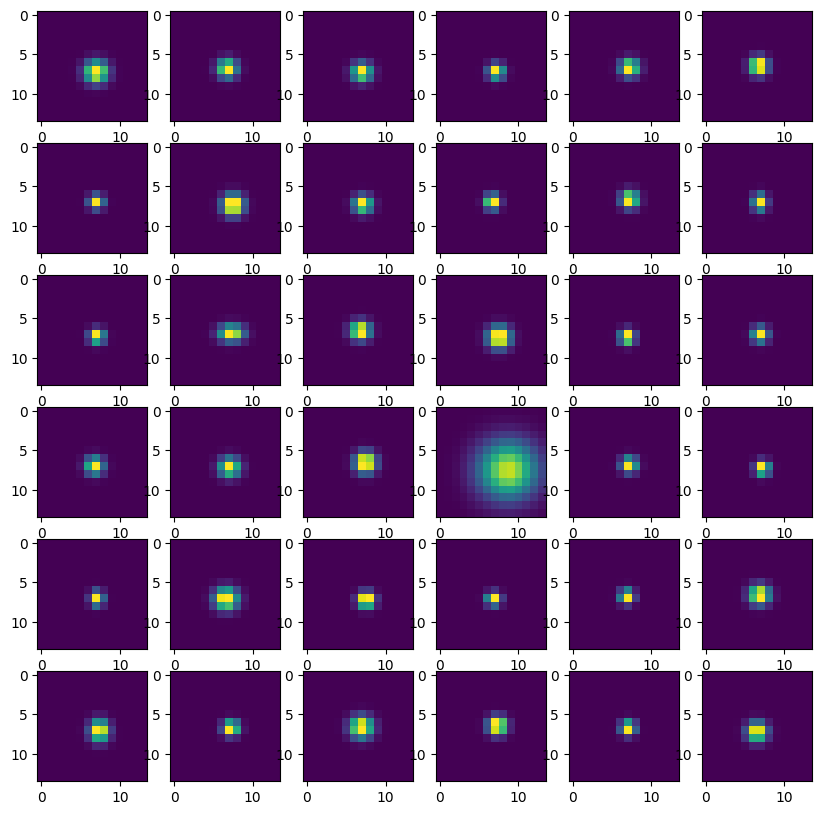

In [21]:
fig = plt.figure(figsize=(10, 10))
for index in range(36):
    ax = fig.add_subplot(6, 6, index + 1)
    model_cutout = Gaussian2D(amplitude=model_fit.amplitude[index],
                              x_mean=model_fit.x_mean[index],
                              y_mean=model_fit.y_mean[index],
                              x_stddev=model_fit.x_stddev[index],
                              y_stddev=model_fit.y_stddev[index])(x, y)
    ax.imshow(model_cutout, vmax=1)

Now compare the fitted values to those determined by the source finding:

Text(0, 0.5, 'Fitted amplitude')

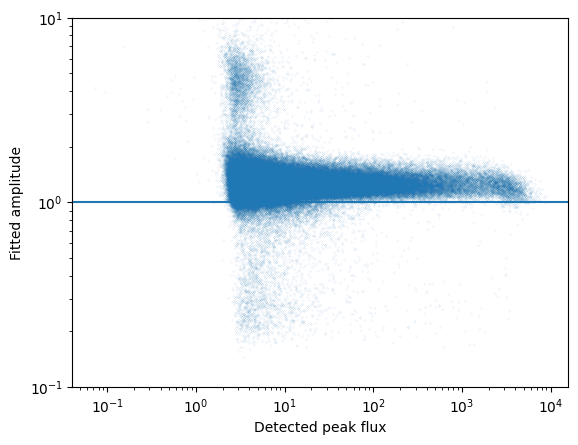

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sources['peak'], model_fit.amplitude, '.', markersize=0.1)
ax.set_ylim(0.1, 10)
ax.axhline(1)
ax.set_xlabel('Detected peak flux')
ax.set_ylabel('Fitted amplitude')


Text(0, 0.5, 'Fitted y position')

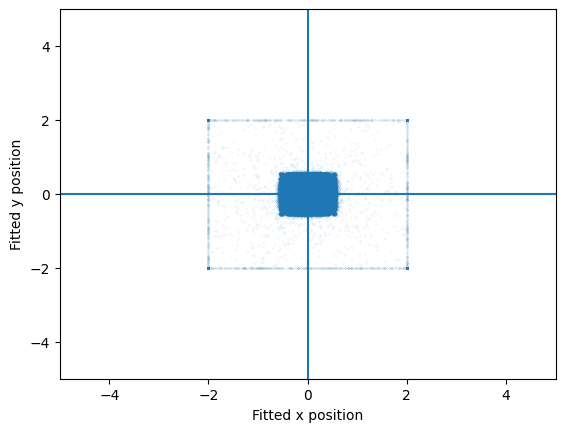

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(model_fit.x_mean - cutout_half_size, model_fit.y_mean - cutout_half_size, '.', markersize=0.1)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axhline(0)
ax.axvline(0)
ax.set_xlabel('Fitted x position')
ax.set_ylabel('Fitted y position')

Text(0, 0.5, 'Fitted y stddev')

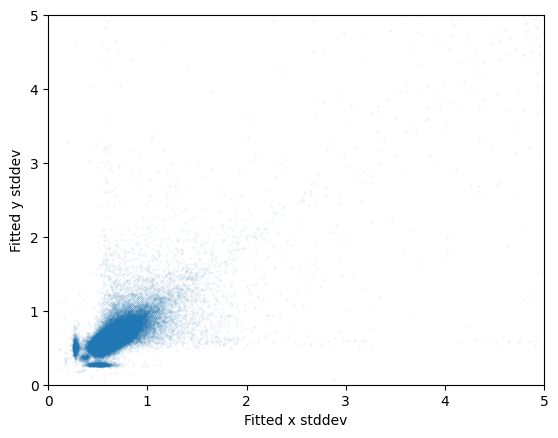

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(model_fit.x_stddev, model_fit.y_stddev, '.', markersize=0.1)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel('Fitted x stddev')
ax.set_ylabel('Fitted y stddev')